# import libraries

In [2]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import glob
import matplotlib.gridspec
import scipy.ndimage

import wrf
import netCDF4
import cmocean

import pandas

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy
import cartopy.io.shapereader

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [3]:
run_info = 'FMAASO'
skip_time=0

# opening mean fields

## control data

In [4]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [5]:
ptot_400 = numpy.load('DATA_ptot_400.npy')
wa_400 = numpy.load('DATA_wa_400.npy')
#ua_400 = numpy.load('DATA_ua_400.npy')
#va_400 = numpy.load('DATA_va_400.npy')
#tk_400 = numpy.load('DATA_tk_400.npy')
#prw_400 = numpy.load('DATA_prw_400.npy')

geopot_400 = numpy.load('DATA_geopot_400.npy')
geopot_stag_400 = numpy.load('DATA_geopot_stag_400.npy')
tk_400 = numpy.load('DATA_tk_400.npy')

In [6]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [7]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [8]:
qvapor_400 = cont_mfds['QVAPOR']
u_400 = cont_mfds['U']
v_400 = cont_mfds['V']
w_400 = cont_mfds['W']

In [9]:
rainc_400 = cont_mfds['RAINC']
rainnc_400 = cont_mfds['RAINNC']

## phys data

In [10]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [11]:
ptot_1000 = numpy.load('DATA_ptot_1000.npy')
wa_1000 = numpy.load('DATA_wa_1000.npy')
#ua_1000 = numpy.load('DATA_ua_1000.npy')
#va_1000 = numpy.load('DATA_va_1000.npy')
#tk_1000 = numpy.load('DATA_tk_1000.npy')
#prw_1000 = numpy.load('DATA_prw_1000.npy')

geopot_1000 = numpy.load('DATA_geopot_1000.npy')
geopot_stag_1000 = numpy.load('DATA_geopot_stag_1000.npy')
tk_1000 = numpy.load('DATA_tk_1000.npy')

In [12]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [13]:
qvapor_1000 = phys_mfds['QVAPOR']
u_1000 = phys_mfds['U']
v_1000 = phys_mfds['V']
w_1000 = phys_mfds['W']

In [14]:
rainc_1000 = phys_mfds['RAINC']
rainnc_1000 = phys_mfds['RAINNC']

## define dx, dy

In [15]:
dx = 50000. # 50,000 m or 50 km
dy = 50000.

# constants

In [16]:
L_v = 2264705.0 # J/kg
c_p = 1005.7 # J/kgK
g = 9.80665 # m/s2

## get landmask

In [17]:
landmask = cont_mfds['LANDMASK'].sel(Time=0).values

In [18]:
lat_indices = ((xlat<=10)&(xlat>=-5))

# calculate raintot and rain diffs

In [19]:
raintot_accum_1000 = rainnc_1000+rainc_1000

raintot_accum_400 = rainnc_400+rainc_400

raintot_1000 = numpy.diff(raintot_accum_1000, axis=0)
raintot_400 = numpy.diff(raintot_accum_400, axis=0)

In [20]:
raintot_diffs = raintot_1000-raintot_400

raintot_diffs_landmask = numpy.copy(raintot_diffs)
raintot_diffs_landmask[:,landmask==0]=numpy.nan
raintot_diffs_lat_subset = raintot_diffs_landmask[:,lat_indices[:,0],:]
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_lat_subset, axis=1)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [21]:
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_latmean[:24,:], axis=0)
raintot_diffs_latmean_day2_10 = numpy.nanmean(raintot_diffs_latmean[24:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# calculate w diffs for height-longitude plot

In [22]:
wa_diffs = wa_1000-wa_400

wa_diffs_landmask = numpy.copy(wa_diffs)
wa_diffs_landmask[:,:,landmask==0]=numpy.nan

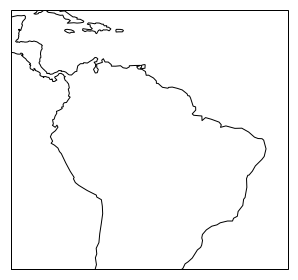

In [23]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})
ax.set_extent([270,330,-30,20])
ax.coastlines()
fig.tight_layout()

# calculate MSE

In [24]:
mse_400 = numpy.load('DATA_mse_400.npy')
mse_1000 = numpy.load('DATA_mse_1000.npy')

# calculate midpoints so that fields are 28x178x288

In [25]:
u_400_midpoints = 0.5*(u_400[:,:,:,1:]+u_400[:,:,:,:-1])
u_400_midpoints = 0.5*(u_400_midpoints[:,1:,1:,1:]+u_400_midpoints[:,:-1,:-1,:-1]).values

In [26]:
u_1000_midpoints = 0.5*(u_1000[:,:,:,1:]+u_1000[:,:,:,:-1])
u_1000_midpoints = 0.5*(u_1000_midpoints[:,1:,1:,1:]+u_1000_midpoints[:,:-1,:-1,:-1]).values

In [27]:
v_400_midpoints = 0.5*(v_400[:,:,1:,:]+v_400[:,:,:-1,:])
v_400_midpoints = 0.5*(v_400_midpoints[:,1:,1:,1:]+v_400_midpoints[:,:-1,:-1,:-1]).values

In [28]:
v_1000_midpoints = 0.5*(v_1000[:,:,1:,:]+v_1000[:,:,:-1,:])
v_1000_midpoints = 0.5*(v_1000_midpoints[:,1:,1:,1:]+v_1000_midpoints[:,:-1,:-1,:-1]).values

In [29]:
wa_400_midpoints = (0.5*(wa_400[:,1:,1:,1:]+wa_400[:,:-1,:-1,:-1]))
wa_1000_midpoints = (0.5*(wa_1000[:,1:,1:,1:]+wa_1000[:,:-1,:-1,:-1]))

In [30]:
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])

In [31]:
geopot_400_midpoints = 0.5*(geopot_400[:,1:,1:,1:]+geopot_400[:,:-1,:-1,:-1])
geopot_1000_midpoints = 0.5*(geopot_1000[:,1:,1:,1:]+geopot_1000[:,:-1,:-1,:-1])

In [32]:
mse_400_midpoints = 0.5*(mse_400[:,1:,1:,1:]+mse_400[:,:-1,:-1,:-1])
mse_1000_midpoints = 0.5*(mse_1000[:,1:,1:,1:]+mse_1000[:,:-1,:-1,:-1])

In [33]:
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])

# calculate dmsedt terms

In [34]:
ntime = 241
nlev = 28

dmsedt will be automatically placed on midpoints

In [35]:
dmsedt_400 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
dmsedt_1000 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [36]:
for t in range(1,ntime-1):
    dmsedt_400[t,:,:,:] = (mse_400_midpoints[t+1,:,:,:]-mse_400_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    dmsedt_1000[t,:,:,:] = (mse_1000_midpoints[t+1,:,:,:]-mse_1000_midpoints[t-1,:,:,:])/7200.

# calculate convergence terms

In [37]:
dudx_400 = numpy.diff(u_400.values, axis=3)/dx
dudx_400 = 0.5*(dudx_400[:,1:,1:,1:]+dudx_400[:,:-1,:-1,:-1])

In [38]:
dudx_1000 = numpy.diff(u_1000.values, axis=3)/dx
dudx_1000 = 0.5*(dudx_1000[:,1:,1:,1:]+dudx_1000[:,:-1,:-1,:-1])

In [39]:
dvdy_400 = numpy.diff(v_400.values, axis=2)/dy
dvdy_400 = 0.5*(dvdy_400[:,1:,1:,1:]+dvdy_400[:,:-1,:-1,:-1])

In [40]:
dvdy_1000 = numpy.diff(v_1000.values, axis=2)/dy
dvdy_1000 = 0.5*(dvdy_1000[:,1:,1:,1:]+dvdy_1000[:,:-1,:-1,:-1])

In [41]:
ptot_400_diff = numpy.diff(ptot_400, axis=1)
ptot_1000_diff = numpy.diff(ptot_1000, axis=1)

In [42]:
geopot_400_diff = numpy.diff(geopot_400, axis=1) # needed for convergence calculation
geopot_1000_diff = numpy.diff(geopot_1000, axis=1)

In [43]:
geopot_stag_400_diff = numpy.diff(geopot_stag_400, axis=1) # needed for advection calculation
geopot_stag_1000_diff = numpy.diff(geopot_stag_1000, axis=1)

In [44]:
dwdz_400 = numpy.diff(w_400, axis=1)/(geopot_stag_400_diff/g)
dwdz_400 = 0.5*(dwdz_400[:,1:,1:,1:]+dwdz_400[:,:-1,:-1,:-1])

dwdz_1000 = numpy.diff(w_1000, axis=1)/(geopot_stag_1000_diff/g)
dwdz_1000 = 0.5*(dwdz_1000[:,1:,1:,1:]+dwdz_1000[:,:-1,:-1,:-1])

pressure coords

In [45]:
convergence_400 = -mse_400_midpoints*(dudx_400 + dvdy_400 + dwdz_400)
convergence_1000 = -mse_1000_midpoints*(dudx_1000 + dvdy_1000 + dwdz_1000)

calculate vertical and horizontal terms separately

In [46]:
convergence_400_vert = -mse_400_midpoints*dwdz_400 #cont_domegadp
convergence_400_horiz = -mse_400_midpoints*(dudx_400 + dvdy_400)

convergence_1000_vert = -mse_1000_midpoints*dwdz_1000 #phys_domegadp
convergence_1000_horiz = -mse_1000_midpoints*(dudx_1000 + dvdy_1000)

# calculate advection terms

In [47]:
cont_dmsedx = numpy.diff(mse_400, axis=3)/dx # diff in y, then take mean 
cont_dmsedx = 0.5*(cont_dmsedx[:,1:,1:,:]+cont_dmsedx[:,:-1,:-1,:])

In [48]:
phys_dmsedx = numpy.diff(mse_1000, axis=3)/dx # diff in y, then take mean 
phys_dmsedx = 0.5*(phys_dmsedx[:,1:,1:,:]+phys_dmsedx[:,:-1,:-1,:])

In [49]:
cont_dmsedy = numpy.diff(mse_400, axis=2)/dy # diff in y, then take mean 
cont_dmsedy = 0.5*(cont_dmsedy[:,1:,:,1:]+cont_dmsedy[:,:-1,:,:-1])

In [50]:
phys_dmsedy = numpy.diff(mse_1000, axis=2)/dy # diff in y, then take mean 
phys_dmsedy = 0.5*(phys_dmsedy[:,1:,:,1:]+phys_dmsedy[:,:-1,:,:-1])

In [51]:
cont_dmsedz = numpy.diff(mse_400, axis=1)/(geopot_400_diff/g)
cont_dmsedz = 0.5*(cont_dmsedz[:,:,1:,1:]+cont_dmsedz[:,:,:-1,:-1])

In [52]:
phys_dmsedz = numpy.diff(mse_1000, axis=1)/(geopot_1000_diff/g)
phys_dmsedz = 0.5*(phys_dmsedz[:,:,1:,1:]+phys_dmsedz[:,:,:-1,:-1])

In [53]:
advection_400 = -(u_400_midpoints*cont_dmsedx + v_400_midpoints*cont_dmsedy + wa_400_midpoints*cont_dmsedz)
advection_1000 = -(u_1000_midpoints*phys_dmsedx + v_1000_midpoints*phys_dmsedy + wa_1000_midpoints*phys_dmsedz)

for pressure terms

calculate vertical and horizontal terms separately

In [54]:
advection_400_vert = -wa_400_midpoints*cont_dmsedz
advection_400_horiz = -(u_400_midpoints*cont_dmsedx + v_400_midpoints*cont_dmsedy)

advection_1000_vert = -wa_1000_midpoints*phys_dmsedz
advection_1000_horiz = -(u_1000_midpoints*phys_dmsedx + v_1000_midpoints*phys_dmsedy)

# calculate time means

Only time mean for qcloud, qrain, ptot

Rest have day1 mean as well

In [55]:
ptot_400_tm = numpy.nanmean(ptot_400[24:,:,:,:], axis=0)
ptot_1000_tm = numpy.nanmean(ptot_1000[24:,:,:,:], axis=0)

In [ ]:
dmsedt_400_tm = numpy.nanmean(dmsedt_400[24:,:,:,:], axis=0)
dmsedt_1000_tm = numpy.nanmean(dmsedt_1000[24:,:,:,:], axis=0)

dmsedt_400_tm_day1 = numpy.nanmean(dmsedt_400[:24,:,:,:], axis=0)
dmsedt_1000_tm_day1 = numpy.nanmean(dmsedt_1000[:24,:,:,:], axis=0)

In [ ]:
advection_400_tm = numpy.nanmean(advection_400[24:,:,:,:], axis=0)
advection_1000_tm = numpy.nanmean(advection_1000[24:,:,:,:], axis=0)

advection_400_tm_day1 = numpy.nanmean(advection_400[:24,:,:,:], axis=0)
advection_1000_tm_day1 = numpy.nanmean(advection_1000[:24,:,:,:], axis=0)

In [ ]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

In [ ]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

calculate vertical and horizontal advection terms

In [ ]:
advection_400_vert_tm = numpy.nanmean(advection_400_vert[24:,:,:,:], axis=0)
advection_1000_vert_tm = numpy.nanmean(advection_1000_vert[24:,:,:,:], axis=0)
advection_400_vert_tm_day1 = numpy.nanmean(advection_400_vert[:24,:,:,:], axis=0)
advection_1000_vert_tm_day1 = numpy.nanmean(advection_1000_vert[:24,:,:,:], axis=0)

advection_400_horiz_tm = numpy.nanmean(advection_400_horiz[24:,:,:,:], axis=0)
advection_1000_horiz_tm = numpy.nanmean(advection_1000_horiz[24:,:,:,:], axis=0)
advection_400_horiz_tm_day1 = numpy.nanmean(advection_400_horiz[:24,:,:,:], axis=0)
advection_1000_horiz_tm_day1 = numpy.nanmean(advection_1000_horiz[:24,:,:,:], axis=0)

In [ ]:
convergence_400_vert_tm = numpy.nanmean(convergence_400_vert[24:,:,:,:], axis=0)
convergence_1000_vert_tm = numpy.nanmean(convergence_1000_vert[24:,:,:,:], axis=0)
convergence_400_vert_tm_day1 = numpy.nanmean(convergence_400_vert[:24,:,:,:], axis=0)
convergence_1000_vert_tm_day1 = numpy.nanmean(convergence_1000_vert[:24,:,:,:], axis=0)

convergence_400_horiz_tm = numpy.nanmean(convergence_400_horiz[24:,:,:,:], axis=0)
convergence_1000_horiz_tm = numpy.nanmean(convergence_1000_horiz[24:,:,:,:], axis=0)
convergence_400_horiz_tm_day1 = numpy.nanmean(convergence_400_horiz[:24,:,:,:], axis=0)
convergence_1000_horiz_tm_day1 = numpy.nanmean(convergence_1000_horiz[:24,:,:,:], axis=0)

In [ ]:
#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-5,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-70,-5,10

#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -65,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [ ]:
xlat_midpoints = 0.5*(xlat[1:,1:]+xlat[:-1,:-1])
xlong_midpoints = 0.5*(xlong[1:,1:]+xlong[:-1,:-1])

In [ ]:
wet_latlon_subset_midpoints = ((xlat_midpoints<=wet_lat_hi) & (xlat_midpoints>=wet_lat_lo) \
                               & (xlong_midpoints<=wet_lon_hi) & (xlong_midpoints>=wet_lon_lo))

dry_latlon_subset_midpoints = ((xlat_midpoints<=dry_lat_hi) & (xlat_midpoints>=dry_lat_lo) \
                               & (xlong_midpoints<=dry_lon_hi) & (xlong_midpoints>=dry_lon_lo))

lat_indices_midpoints = ((xlat_midpoints<=10)&(xlat_midpoints>=-10))

In [ ]:
wet_latlon_subset = ((xlat<=wet_lat_hi) & (xlat>=wet_lat_lo) \
                               & (xlong<=wet_lon_hi) & (xlong>=wet_lon_lo))

dry_latlon_subset = ((xlat<=dry_lat_hi) & (xlat>=dry_lat_lo) \
                               & (xlong<=dry_lon_hi) & (xlong>=dry_lon_lo))

lat_indices = ((xlat<=10)&(xlat>=-10))

# pulling out wet and dry regions

In [ ]:
dmsedt_400_wet_region = numpy.nanmean(dmsedt_400_tm[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_400_dry_region = numpy.nanmean(dmsedt_400_tm[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_1000_wet_region = numpy.nanmean(dmsedt_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_1000_dry_region = numpy.nanmean(dmsedt_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_400_wet_region_day1 = numpy.nanmean(dmsedt_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_400_dry_region_day1 = numpy.nanmean(dmsedt_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_1000_wet_region_day1 = numpy.nanmean(dmsedt_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_1000_dry_region_day1 = numpy.nanmean(dmsedt_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [ ]:
convergence_400_wet_region = numpy.nanmean(convergence_400_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region = numpy.nanmean(convergence_400_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region = numpy.nanmean(convergence_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region = numpy.nanmean(convergence_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_wet_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [ ]:
convergence_400.shape

In [ ]:
advection_400_wet_region = numpy.nanmean(advection_400_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region = numpy.nanmean(advection_400_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region = numpy.nanmean(advection_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region = numpy.nanmean(advection_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_wet_region_day1 = numpy.nanmean(advection_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region_day1 = numpy.nanmean(advection_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [ ]:
wa_400_tm = numpy.nanmean(wa_400[24:,:,:,:], axis=0)
wa_1000_tm = numpy.nanmean(wa_1000[24:,:,:,:], axis=0)

wa_400_tm_day1 = numpy.nanmean(wa_400[:24,:,:,:], axis=0)
wa_1000_tm_day1 = numpy.nanmean(wa_1000[:24,:,:,:], axis=0)

In [ ]:
wa_400_wet = numpy.nanmean(wa_400_tm[:,wet_latlon_subset],axis=1)
wa_400_dry = numpy.nanmean(wa_400_tm[:,dry_latlon_subset],axis=1)

wa_1000_wet = numpy.nanmean(wa_1000_tm[:,wet_latlon_subset],axis=1)
wa_1000_dry = numpy.nanmean(wa_1000_tm[:,dry_latlon_subset],axis=1)

wa_400_wet_day1 = numpy.nanmean(wa_400_tm_day1[:,wet_latlon_subset],axis=1)
wa_400_dry_day1 = numpy.nanmean(wa_400_tm_day1[:,dry_latlon_subset],axis=1)

wa_1000_wet_day1 = numpy.nanmean(wa_1000_tm_day1[:,wet_latlon_subset],axis=1)
wa_1000_dry_day1 = numpy.nanmean(wa_1000_tm_day1[:,dry_latlon_subset],axis=1)

In [ ]:
convergence_400_vert_wet_region = numpy.nanmean(convergence_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region = numpy.nanmean(convergence_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region = numpy.nanmean(convergence_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region = numpy.nanmean(convergence_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_vert_wet_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [ ]:
convergence_400_horiz_wet_region = numpy.nanmean(convergence_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region = numpy.nanmean(convergence_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region = numpy.nanmean(convergence_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region = numpy.nanmean(convergence_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_horiz_wet_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [ ]:
advection_400_vert_wet_region = numpy.nanmean(advection_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region = numpy.nanmean(advection_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region = numpy.nanmean(advection_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region = numpy.nanmean(advection_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_vert_wet_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [ ]:
advection_400_horiz_wet_region = numpy.nanmean(advection_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region = numpy.nanmean(advection_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region = numpy.nanmean(advection_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region = numpy.nanmean(advection_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_horiz_wet_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

# plot vertical changes using ptot change

In [ ]:
ptot_400_dry_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,dry_latlon_subset_midpoints], axis=(0,2))
ptot_400_wet_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,wet_latlon_subset_midpoints], axis=(0,2))

In [ ]:
ptot_400_dry_region = numpy.nanmean(ptot_400[:,:,dry_latlon_subset], axis=(0,2))
ptot_400_wet_region = numpy.nanmean(ptot_400[:,:,wet_latlon_subset], axis=(0,2))

In [ ]:
diff_wet_region_dmsedt = dmsedt_1000_wet_region-dmsedt_400_wet_region
diff_dry_region_dmsedt = dmsedt_1000_dry_region-dmsedt_400_dry_region

diff_wet_region_dmsedt_day1 = dmsedt_1000_wet_region_day1-dmsedt_400_wet_region_day1
diff_dry_region_dmsedt_day1 = dmsedt_1000_dry_region_day1-dmsedt_400_dry_region_day1

In [ ]:
diff_wet_region_conv = convergence_1000_wet_region-convergence_400_wet_region
diff_dry_region_conv = convergence_1000_dry_region-convergence_400_dry_region

diff_wet_region_conv_day1 = convergence_1000_wet_region_day1-convergence_400_wet_region_day1
diff_dry_region_conv_day1 = convergence_1000_dry_region_day1-convergence_400_dry_region_day1

In [ ]:
diff_wet_region_adv = advection_1000_wet_region-advection_400_wet_region
diff_dry_region_adv = advection_1000_dry_region-advection_400_dry_region

diff_wet_region_adv_day1 = advection_1000_wet_region_day1-advection_400_wet_region_day1
diff_dry_region_adv_day1 = advection_1000_dry_region_day1-advection_400_dry_region_day1

In [ ]:
wa_diff_wet_region = wa_1000_wet-wa_400_wet
wa_diff_dry_region = wa_1000_dry-wa_400_dry

wa_diff_wet_region_day1 = wa_1000_wet_day1-wa_400_wet_day1
wa_diff_dry_region_day1 = wa_1000_dry_day1-wa_400_dry_day1

same but for vert and horiz split up

In [ ]:
diff_wet_region_vert_conv = convergence_1000_vert_wet_region-convergence_400_vert_wet_region
diff_dry_region_vert_conv = convergence_1000_vert_dry_region-convergence_400_vert_dry_region

diff_wet_region_vert_conv_day1 = convergence_1000_vert_wet_region_day1-convergence_400_vert_wet_region_day1
diff_dry_region_vert_conv_day1 = convergence_1000_vert_dry_region_day1-convergence_400_vert_dry_region_day1

diff_wet_region_vert_adv = advection_1000_vert_wet_region-advection_400_vert_wet_region
diff_dry_region_vert_adv = advection_1000_vert_dry_region-advection_400_vert_dry_region

diff_wet_region_vert_adv_day1 = advection_1000_vert_wet_region_day1-advection_400_vert_wet_region_day1
diff_dry_region_vert_adv_day1 = advection_1000_vert_dry_region_day1-advection_400_vert_dry_region_day1

In [ ]:
diff_wet_region_horiz_conv = convergence_1000_horiz_wet_region-convergence_400_horiz_wet_region
diff_dry_region_horiz_conv = convergence_1000_horiz_dry_region-convergence_400_horiz_dry_region

diff_wet_region_horiz_conv_day1 = convergence_1000_horiz_wet_region_day1-convergence_400_horiz_wet_region_day1
diff_dry_region_horiz_conv_day1 = convergence_1000_horiz_dry_region_day1-convergence_400_horiz_dry_region_day1

diff_wet_region_horiz_adv = advection_1000_horiz_wet_region-advection_400_horiz_wet_region
diff_dry_region_horiz_adv = advection_1000_horiz_dry_region-advection_400_horiz_dry_region

diff_wet_region_horiz_adv_day1 = advection_1000_horiz_wet_region_day1-advection_400_horiz_wet_region_day1
diff_dry_region_horiz_adv_day1 = advection_1000_horiz_dry_region_day1-advection_400_horiz_dry_region_day1

# dmsedt time series

In [ ]:
ptot_400_dry_latlon = ptot_400_midpoints[:,:,dry_latlon_subset_midpoints]

dmsedt_400_dry_latlon = dmsedt_400[:,:,dry_latlon_subset_midpoints]
dmsedt_1000_dry_latlon = dmsedt_1000[:,:,dry_latlon_subset_midpoints]
dmsedt_diff_dry_latlon = dmsedt_1000_dry_latlon-dmsedt_400_dry_latlon

dmsedt_400_dry_latlon_areamean = numpy.nanmean(dmsedt_400_dry_latlon, axis=2)
dmsedt_diff_dry_latlon_areamean = numpy.nanmean(dmsedt_diff_dry_latlon, axis=2)
ptot_400_dry_latlon_areamean = numpy.nanmean(ptot_400_dry_latlon, axis=2)

In [ ]:
convergence_400_dry_latlon = convergence_400[:,:,dry_latlon_subset_midpoints]
convergence_1000_dry_latlon = convergence_1000[:,:,dry_latlon_subset_midpoints]

advection_400_dry_latlon = advection_400[:,:,dry_latlon_subset_midpoints]
advection_1000_dry_latlon = advection_1000[:,:,dry_latlon_subset_midpoints]

advection_diff_dry_latlon = advection_1000_dry_latlon-advection_400_dry_latlon
convergence_diff_dry_latlon = convergence_1000_dry_latlon-convergence_400_dry_latlon

advection_400_dry_latlon_areamean = numpy.nanmean(advection_400_dry_latlon, axis=2)
convergence_400_dry_latlon_areamean = numpy.nanmean(convergence_400_dry_latlon, axis=2)
advection_diff_dry_latlon_areamean = numpy.nanmean(advection_diff_dry_latlon, axis=2)
convergence_diff_dry_latlon_areamean = numpy.nanmean(convergence_diff_dry_latlon, axis=2)

In [ ]:
xx_dmsedt, pp_dmsedt = numpy.meshgrid(numpy.arange(241), ptot_400_dry_latlon_areamean[0,:])

In [ ]:
fontsize = 12

fig = mp.figure(figsize=(6.5,2))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)
contour_plot = ax.pcolormesh(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

ax.set_ylim(1000,300)
#ax.set_xlim(0,240)
ax.set_xlim(0,84)

ax.set_xlabel('hour', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

fig.colorbar(contour_plot)

In [ ]:
fontsize = 12

fig = mp.figure(figsize=(6.5,2))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)
contour_plot = ax.pcolormesh(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, vmin=-.25, vmax=.25)

contour_line = ax.contour(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax.set_ylim(1000,300)
ax.set_xlim(0,84)

ax.set_xlabel('hour', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

fig.colorbar(contour_plot)



In [ ]:
fontsize = 12

fig = mp.figure(figsize=(4.25,6))


ax1 = fig.add_subplot(311)
ax1.tick_params(labelsize=fontsize)
# contour_plot1 = ax1.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_400_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.2, vmax=.2)

levels = numpy.arange(-.15,.151,0.0125)
contour_plot1 = ax1.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line1 = ax1.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax1.set_ylim(1000,300)
ax1.set_xlim(0,24)
ax1.set_xticks([i for i in range(0,25,6)])
ax1.set_yticks([400,600,800,1000])
#ax1.set_xlabel('hour', fontsize=fontsize)
ax1.set_ylabel('hPa', fontsize=fontsize)



ax2 = fig.add_subplot(312)
ax2.tick_params(labelsize=fontsize)
# contour_plot2 = ax2.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_diff_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

levels = numpy.arange(-0.05,0.051,0.01)

contour_plot2 = ax2.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line2 = ax2.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax2.set_ylim(1000,300)
#ax.set_xlim(0,240)
ax2.set_xlim(0,24)
#ax2.set_xlabel('hour', fontsize=fontsize)
ax2.set_ylabel('hPa', fontsize=fontsize)
ax2.set_xticks([i for i in range(0,25,6)])
ax2.set_yticks([400,600,800,1000])

ax2.add_patch(matplotlib.patches.Rectangle((12,700),8,-400, \
                                           fill=False, \
                                           edgecolor='0.1', lw=2, clip_on=False))



ax3 = fig.add_subplot(313)
ax3.tick_params(labelsize=fontsize)

levels = numpy.arange(-0.015,0.0151,0.0025)
contour_plot3 = ax3.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, levels=levels, extend='both')
contour_line3 = ax3.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax3.set_ylim(700,300)
#ax.set_xlim(0,240)
ax3.set_xlim(12,20)
ax3.set_xlabel('hour', fontsize=fontsize)
ax3.set_ylabel('hPa', fontsize=fontsize)
ax3.set_xticks([i for i in range(12,21,2)])
ax3.set_yticks([300,400,500,600,700])

for c in contour_plot1.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)
for c in contour_plot2.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)
for c in contour_plot3.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)

ax1.text(s='(a) control dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(b) $\Delta$ dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(c) $\Delta$ dMSE/dt zoom', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax3.transAxes)

fig.tight_layout(h_pad=2)

ax1pos = ax1.get_position()
cbar_ax1 = fig.add_axes([ax1pos.x1+0.05, ax1pos.y0, 0.03, ax1pos.height])
cbar1 = fig.colorbar(contour_plot1, cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.add_lines(contour_line1)
cbar1.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar1.set_ticks([-.1,0,.1])

for c in cbar_ax1.collections:
    c.set_edgecolor('face')

ax2pos = ax2.get_position()
cbar_ax2 = fig.add_axes([ax2pos.x1+0.05, ax2pos.y0, 0.03, ax2pos.height])
cbar2 = fig.colorbar(contour_plot2, cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar2.add_lines(contour_line2)

for c in cbar_ax2.collections:
    c.set_edgecolor('face')

ax3pos = ax3.get_position()
cbar_ax3 = fig.add_axes([ax3pos.x1+0.05, ax3pos.y0, 0.03, ax3pos.height])
cbar3 = fig.colorbar(contour_plot3, cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.add_lines(contour_line3)
cbar3.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar3.set_ticks([-.01,0,.01])

for c in cbar_ax3.collections:
    c.set_edgecolor('face')

conpatch = matplotlib.patches.ConnectionPatch(xyA=(12,300), \
                                              xyB=(12,700), \
                                              coordsA='data', \
                                              coordsB='data', \
                                              axesA=ax3, \
                                              axesB=ax2, \
                                              color='0.1')
ax3.add_artist(conpatch)

conpatch = matplotlib.patches.ConnectionPatch(xyA=(20,300), \
                                              xyB=(20,700), \
                                              coordsA='data', \
                                              coordsB='data', \
                                              axesA=ax3, \
                                              axesB=ax2, \
                                              color='0.1')

ax3.add_artist(conpatch)

fig.savefig('../figures/MAIN_fig10.pdf', dpi=300, bbox_inches='tight', transparent=True)